In [306]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="dark")
%matplotlib inline
''' %matplotlib inline sets the backend of matplotlib to
the 'inline' backend. When using the 'inline' backend,
your matplotlib graphs will be included in your notebook,
next to the code.'''

" %matplotlib inline sets the backend of matplotlib to\nthe 'inline' backend. When using the 'inline' backend,\nyour matplotlib graphs will be included in your notebook,\nnext to the code."

# A bi-character level 1-layer NN Language Model
A character level LM predicts the next chracter in a sequence given already seen some sequence of characters before it.

in name.txt we have some names, we want to create a LM to create some new names!

In [307]:
words = open('names.txt', 'r').read().splitlines()

In [308]:
import  torch

In [309]:
'''
To get same results when sampling during different runs.
If you are using cuDNN, you should set the deterministic behavior.
This might make your code quite slow, but might be a good method to check your code and deactivate it later.
'''
torch.backends.cudnn.deterministic = True

In [310]:
# sets takes an input, create a set of all items,
# & doesn't allow duplicates :)
# then we want a sorted list of course, the order matters! 
chars = sorted(list(set(''.join(words))))
# a map or dict:
# start from 1
s_to_i = { s:i for i, s in enumerate(chars, start=1)}
s_to_i['.'] = 0
i_to_s = { i:s for s,i in s_to_i.items()}

## create the training set of bigrams (x,y)

#### torch.Tensor VS torch.tensor
**Recommended: torch.tensor(data)** :)

In PyTorch torch.Tensor is the main tensor class. So `all tensors are just instances of torch.Tensor`.

When you call torch.Tensor() you will get an `empty tensor without any data` just like the Value objects.

it is no problem creating an empty tensor instance of torch.Tensor without data by calling:

`tensor_without_data = torch.Tensor()`

if you also give it data, it must also **`explicitly set the dtype later as well`**.

**But on the other side:**

`torch.tensor` is a `function` which returns a tensor, and `data must be given as the input`

`tensor_with_data = torch.tensor(data=['must be filled'])

it also **`automatically infer the dtype`** of the data

In [311]:
xs, ys = [], []
for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = s_to_i[ch1]
        idx2 = s_to_i[ch2]
        xs.append(idx1) # input : ch1
        ys.append(idx2) # predict ch2
        print(ch1, ch2)
xs = torch.tensor(xs)
# ys = torch.Tensor(ys)
ys = torch.tensor(ys)
print(xs)
print(ys)
batch_size = xs.shape[0]

. e
e m
m m
m a
a .
tensor([ 0,  5, 13, 13,  1])
tensor([ 5, 13, 13,  1,  0])


### Encode xs & ys
both input and output have 27 states.

idx or counts of characters is not a suitable data to be given to NN or even ask it to prodict bc:

1- they don't represent the real data to learn correlation from.

2- input & outputs must be float & differentiable

let's use dummy or one-hot encoding

xs & ys they are both characters. so the dimension of input = number of classes.
so we use a same encoding for both. **`This encoding is basically a prior empirical distribution`** and is very **important for the loss function** as you will see.

In [312]:
import torch.nn.functional as F

batch_size=5 indim=27


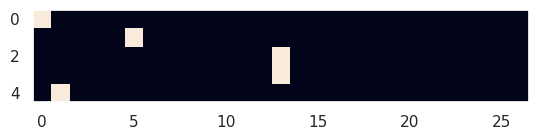

In [313]:
xenc = F.one_hot(xs, num_classes = 27).float()
plt.imshow(xenc) # shape : 5 sample, 27 input dimension
indim = xenc.shape[1]
nclass = indim
print(f'{batch_size=} {indim=}')


## building a single Neuron Model in PyTorch

In [314]:
# 27 weights for a single Neuron
g = torch.Generator().manual_seed(2147483647)
num_neurons = 1
W = torch.randn(indim, num_neurons, generator=g) # from normal:N(μ=0,σ=1)
W.dtype

torch.float32

In [315]:
# Matrix multiplication operator in PyTorch : @
# * 1 w for each dimension of input
# ! xenc:5s,27d @ W:27d,1
# * out: firing rate of "1 neuron" for 5 samples in batch 
xenc @ W

tensor([[ 1.5674],
        [-0.0296],
        [ 0.0380],
        [ 0.0380],
        [-0.2373]])

## Building a simple Fully-Connected Layer in PyTorch
just a Matrix Multiplication

In [316]:
# 27 weights (for each d) of 27 Neurons for each output class
# ! remember nclass = indim but only in Bigram!!!
g = torch.Generator().manual_seed(2147483647)
W = torch.randn(indim, nclass, generator=g) # from normal:N(μ=0,σ=1)

In [317]:
import itertools
def plot_heatmap(tensor, nrow, ncol):
    # if tensor.requires_grad:
    #     t = tensor.detach().numpy()
    # plot the heatmap
    plt.figure(figsize=(15,50))
    plt.imshow(tensor.detach().numpy(), cmap= 'Blues')
    # manually write text on each cell (seaborn annot doesn't look good)
    for i, j in itertools.product(range(nrow), range(ncol)):
        # x:col, y:rows, the origin is top left corner, makes bottom <->top
        plt.text(x=j, y=i, s=f'{tensor[i,j].item():.2f}', ha='center', va='top', color='grey')
    plt.axis('off')

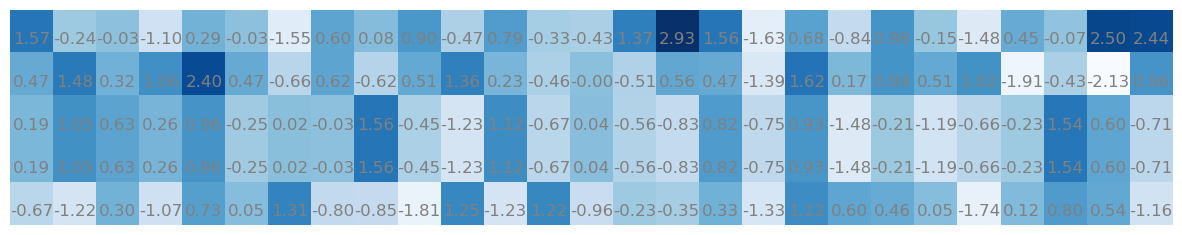

In [318]:
# Matrix multiplication operator in PyTorch : @
# * 1 w for each dimension of input of each neuron
# ! xemc:5s,27d @ W:27d,27n
# * out: firing rate of 27 neurons for 5 samples in batch
plot_heatmap(xenc @ W, batch_size, indim)

In [319]:
(xenc @ W)[3,13] # 3rd sample @ 13th Neuron

tensor(0.0379)

In [320]:
xenc[3,:] @ W[:,13]

tensor(0.0379)

We have only one input layer which is xs and an output layer.

so we don't use any bias.

## What should be the output of 27 Neurons for 5 samples
1- Since we have 27 output N (characters), we want each of Neuron to `represent the probability of a character (0<p<1 & sum up to 1)` 

2- To do that we first `need sth in the output` that we can `interpret as counts (always +)` so that then we can divide them by the sum.

3- The current output of the Neural Net is both - & + floats. `If we exponentiate them, they become always +` and we can interpret them as the counts.

4- That's why the current output of Neurons `before exponentiation or counts` is called **`log-counts or logits`**

5- This is whole exponentiation & normalization is called **`Softmax`** which is an **activation function for the output layer** of a NN

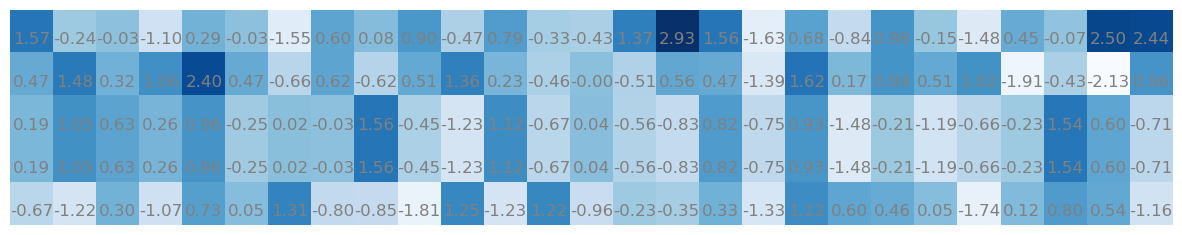

In [321]:
logits = xenc @ W # * log counts
plot_heatmap(logits, batch_size, nclass)

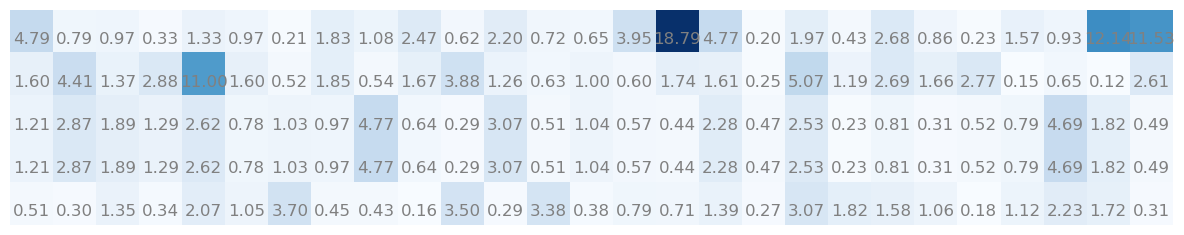

In [322]:
counts = logits.exp() # equivalent to counts
plot_heatmap(counts, batch_size, nclass)

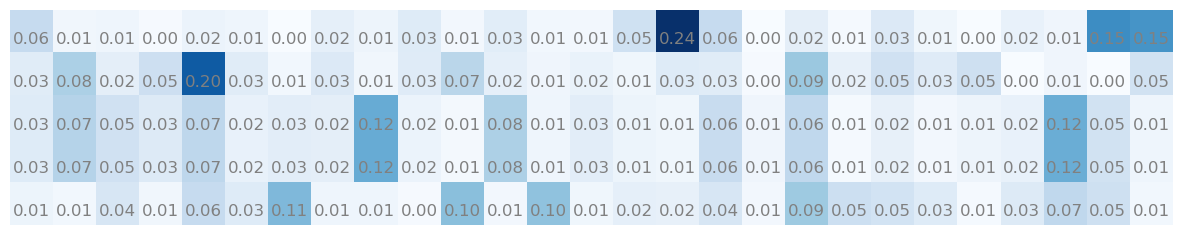

In [323]:
# To compute prop of characters for each sample (rows), we need to divide the character counts by sum the all counts of sample (dim = 1)
# To make it Broadcastable, the counts shape is [batch_size, indim] and the sum is [5, 1]
# equal dimensions, or one is 1, or one doesn't exit
# PyTorch copy 27 cols (dim) from this 2-D column vector
# then it divides pair-wise each entry
# meaning it divides each entry at row i by the sum of row i
probs = counts / counts.sum(dim=1 , keepdim=True)
plot_heatmap(probs, batch_size, nclass)

### computing Expected Negative Log Likelihood (loss)
it has all properties of a loss:
    
    - always +
    
    - the closer to 0, the better the model

for the **`empirical prior distribution`**, here we assume that it is **`one-hot`**, meaning 1 for the true answer and zero for others. so basically we just need to sum the NlogLikelihood for the label and ignore the probability of other characters.

so for loss or expected NLL, we only need to sum up the model probability of those characters with index in ys

In [324]:
# previously, in bigram, we could only compute NLL for one sample at a time
# With NN we can compute it for a batch of input data points in parallel
# so 
Nlog_likelihood = torch.zeros(batch_size)
for s in range(batch_size):
    # i-th bigram:
    x = xs[s].item() # input character index
    y = ys[s].item() # label character index
    print('--------')
    print(f'bigram example {s+1}: {i_to_s[x]}{i_to_s[y]} (indexes {x},{y})')
    print(f'input to the neural net: {x} ({i_to_s[x]})')
    # print(f'output probabilities from the neural net: {probs[idx]}')
    print(f'label (actual next character): {y} ({i_to_s[y]})')
    p = probs[s, y]
    print(f'probability assigned by the net to the the correct character: {p.item()}')
    Nlogp = -1 * torch.log(p)
    print(f'negative log likelihood for this sample: {Nlogp.item()}')
    Nlog_likelihood[s] = Nlogp
print(f'========\nExpected negative log likelihood, i.e. loss = {Nlog_likelihood.mean().item()}')

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0 (.)
label (actual next character): 5 (e)
probability assigned by the net to the the correct character: 0.01228625513613224
negative log likelihood for this sample: 4.399273872375488
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5 (e)
label (actual next character): 13 (m)
probability assigned by the net to the the correct character: 0.018050700426101685
negative log likelihood for this sample: 4.014570713043213
--------
bigram example 3: mm (indexes 13,13)
input to the neural net: 13 (m)
label (actual next character): 13 (m)
probability assigned by the net to the the correct character: 0.026691533625125885
negative log likelihood for this sample: 3.623408794403076
--------
bigram example 4: ma (indexes 13,1)
input to the neural net: 13 (m)
label (actual next character): 1 (a)
probability assigned by the net to the the correct character: 0.07367686182260513
negative log likelihood for this samp

The smaller version of above:

In [325]:
nll = 0.0
for s in range(batch_size):
    nll += -1 * probs[s, ys[s].item()].log()
loss = nll/batch_size
loss

tensor(3.7693)

In [326]:
# even more compact
# ****! you can index with tensors :))))))) great!!!
print(torch.arange(batch_size))
print(ys)
# index with them
probs[torch.arange(batch_size), ys]

tensor([0, 1, 2, 3, 4])
tensor([ 5, 13, 13,  1,  0])


tensor([0.0123, 0.0181, 0.0267, 0.0737, 0.0150])

In [327]:
loss = -probs[torch.arange(batch_size), ys].log().mean()
loss

tensor(3.7693)

## The whole Forward pass summary

In [328]:
g = torch.Generator().manual_seed(2147483647)
# ! W requires grad!!!
W = torch.randn(size=(indim,nclass), generator=g, requires_grad=True)

In [329]:
xenc = F.one_hot(xs, num_classes = 27).float()
batch_size = xenc.shape[0]
indim = xenc.shape[1]
nclass = indim
logits = xenc @ W # * log counts [b, nclass]
counts = logits.exp() # * equivalent to counts [b, nclass]
probs = counts / counts.sum(dim=1 , keepdim=True) #[b, nclass]
# just the 
loss = -probs[torch.arange(batch_size), ys].log().mean()

# Backward Path

In [330]:
# set the weight grads to None, PyTorch interpret it as 0
# but None is more efficient
W.grad = None
loss.backward()

looking at the gradients and probabilities, we can see that:

1- **Only the gradients of the `weights connected to those in-our-batch one-hot inputs (.ema inputs) are non-zero`**!!

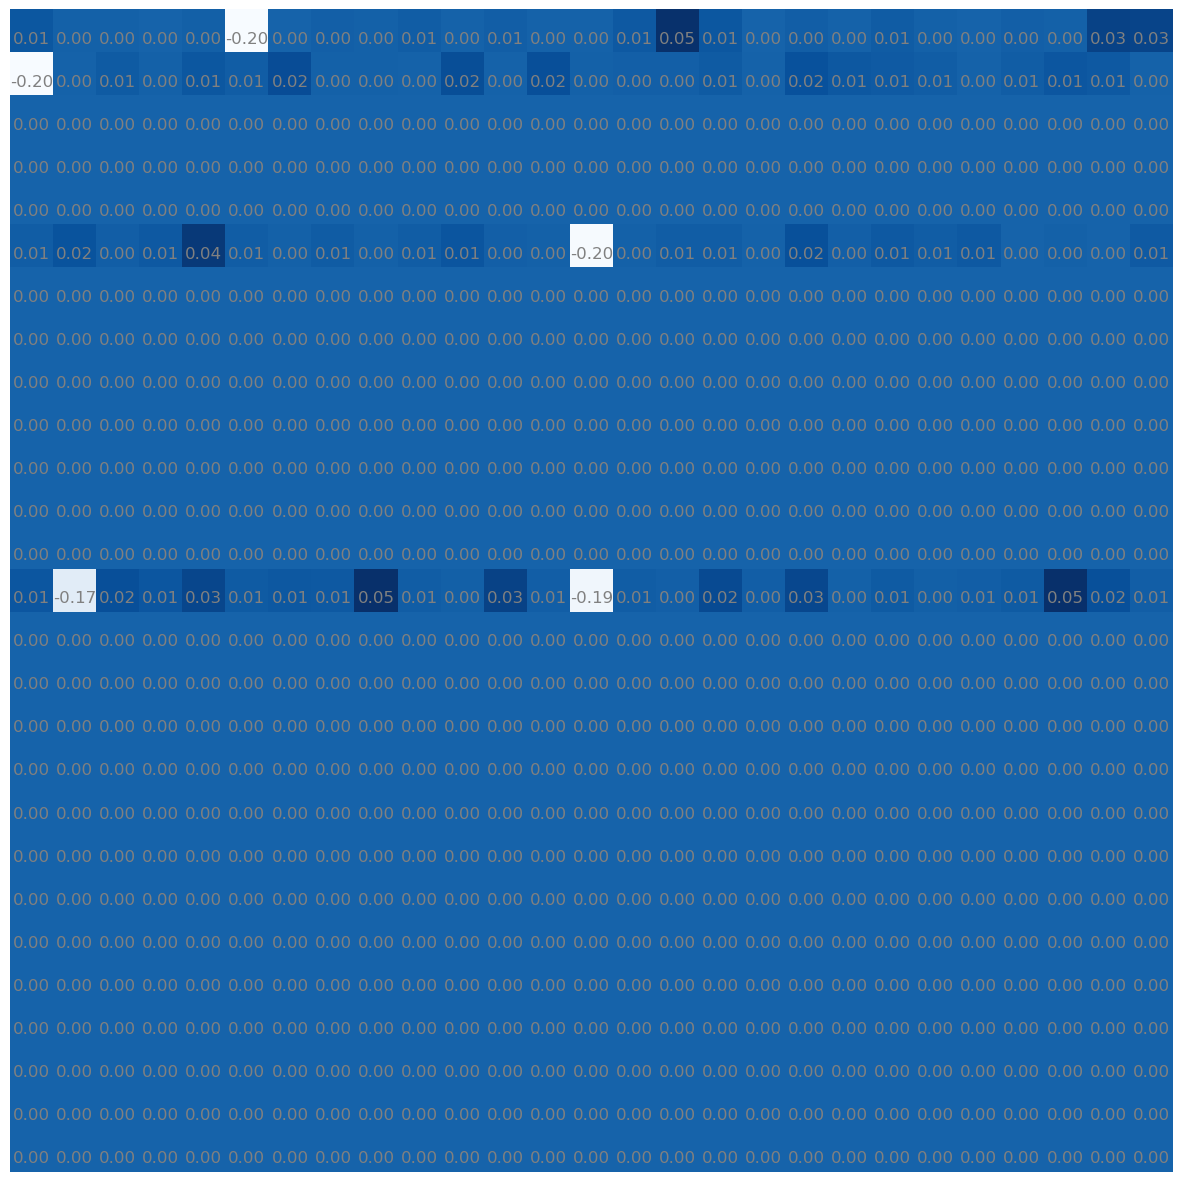

In [331]:
plot_heatmap(W.grad, indim, nclass) # row : which of the 27 on-hot inputs - col: which of the 27 outputs

So lets focus on them

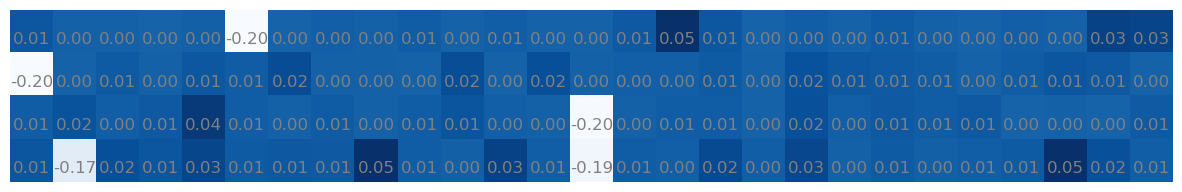

In [332]:
# value of gradients
a = W.grad[ys.sort(dim=0).values.unique()]
plot_heatmap(a, a.shape[0], nclass) # a.shape[0] bc we have might have repetitive characters

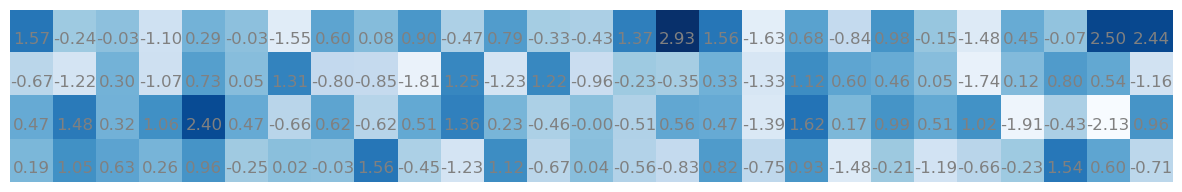

In [333]:
# * value of weights
a = W[ys.sort(dim=0).values.unique()]
plot_heatmap(a, a.shape[0], nclass) # a.shape[0] bc we have might have repetitive characters

2. we can also see that **those weight that was `initialized with a high value`**, and **`causing high probability for wrong classes`**, now **`have a high + gradient`**, meaning **hey will go down with backprop to decrease the loss for this batch**!

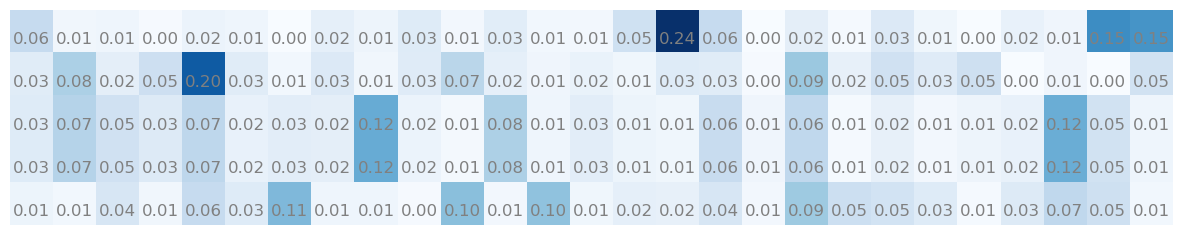

In [334]:

plot_heatmap(probs, batch_size, nclass) # * we have repetitive characters. rows: .emma

## Updating weights

In [335]:
lr = 0.1
print(loss.item())
W.data -= lr *W.grad

3.7693049907684326


In [336]:
logits = xenc @ W # * log counts [b, nclass]
counts = logits.exp() # * equivalent to counts [b, nclass]
probs = counts / counts.sum(dim=1 , keepdim=True) #[b, nclass]
# just the 
loss = -probs[torch.arange(5), ys].log().mean()
loss

tensor(3.7492, grad_fn=<NegBackward0>)

## Loss decreased :))))
next file we put everything together!

#### PyTorch Loss-Input Confusion (Cheatsheet)

- `torch.nn.functional.binary_cross_entropy` takes logistic sigmoid values as inputs
- `torch.nn.functional.binary_cross_entropy_with_logits` takes logits as inputs 
- `torch.nn.functional.cross_entropy` takes logits as inputs (performs `log_softmax` internally)
- `torch.nn.functional.nll_loss` is like `cross_entropy` but takes log-probabilities (log-softmax) values as inputs